In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error

In [2]:
# Importing the training and testing sets
%run "./Data Splitting.ipynb"

In [3]:
grouped_df = grouped_df[["REPORT_DATE","IS_CODE6_ENABLED","REVENUE"]]
grouped_df

,REPORT_DATE,IS_CODE6_ENABLED,REVENUE
0,2022-01-01,True,51542876.0
1,2022-01-02,True,50323396.0
2,2022-01-03,False,40495420.0
3,2022-01-04,False,38233080.0
4,2022-01-05,False,38971034.0
...,...,...,...
724,2023-12-27,True,45294984.0
725,2023-12-28,True,46355479.0
726,2023-12-29,True,46790381.0
727,2023-12-30,True,50994081.0


<h3>Let us visualize the target value's fluctuation to see if it is stationary</h3>

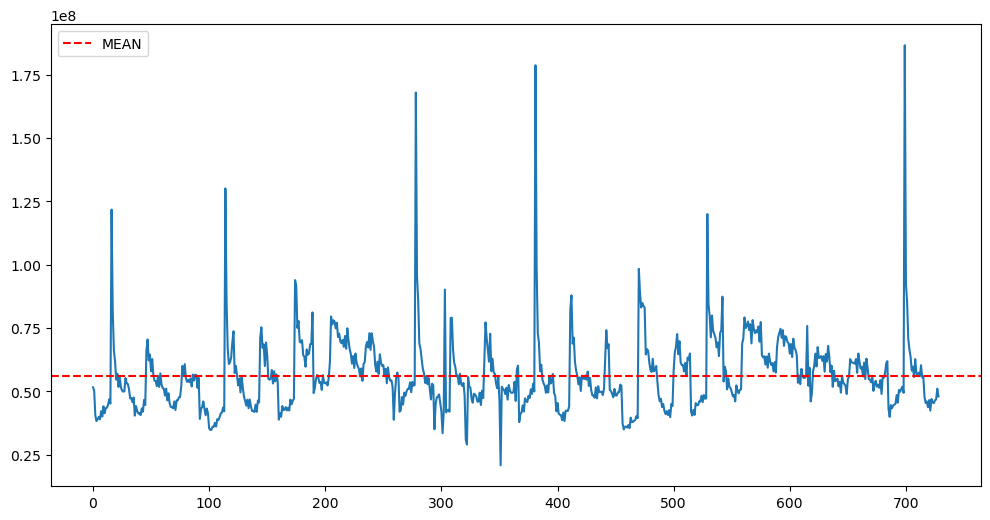

In [4]:
plt.figure(figsize=(12,6))
plt.plot(grouped_df["REVENUE"].values)
plt.axhline(grouped_df["REVENUE"].mean(),c="r",label="MEAN",linestyle="--")
plt.legend()

In [5]:
grouped_df["STATIONARY_REVENUE"] = np.log(grouped_df['REVENUE'])
grouped_df.head()

,REPORT_DATE,IS_CODE6_ENABLED,REVENUE,STATIONARY_REVENUE
0,2022-01-01,True,51542876.0,17.757925
1,2022-01-02,True,50323396.0,17.733981
2,2022-01-03,False,40495420.0,17.516699
3,2022-01-04,False,38233080.0,17.459212
4,2022-01-05,False,38971034.0,17.478329


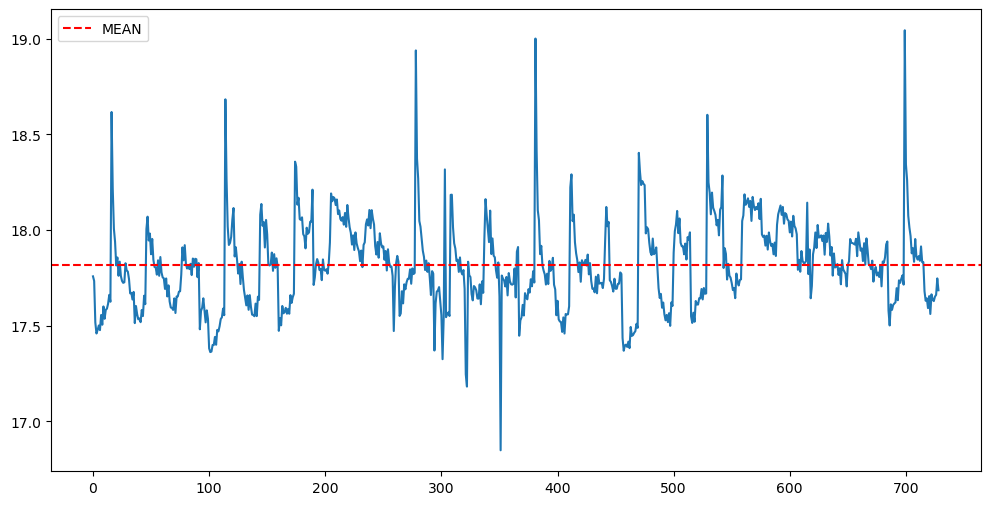

In [6]:
plt.figure(figsize=(12,6))
plt.plot(grouped_df["STATIONARY_REVENUE"].values)
plt.axhline(grouped_df["STATIONARY_REVENUE"].mean(),c="r",label="MEAN",linestyle="--")
plt.legend()

In [7]:
grouped_df["STATIONARY_REVENUE"] = grouped_df["STATIONARY_REVENUE"].diff()
grouped_df.head()

,REPORT_DATE,IS_CODE6_ENABLED,REVENUE,STATIONARY_REVENUE
0,2022-01-01,True,51542876.0,NaN
1,2022-01-02,True,50323396.0,-0.023944
2,2022-01-03,False,40495420.0,-0.217281
3,2022-01-04,False,38233080.0,-0.057488
4,2022-01-05,False,38971034.0,0.019118


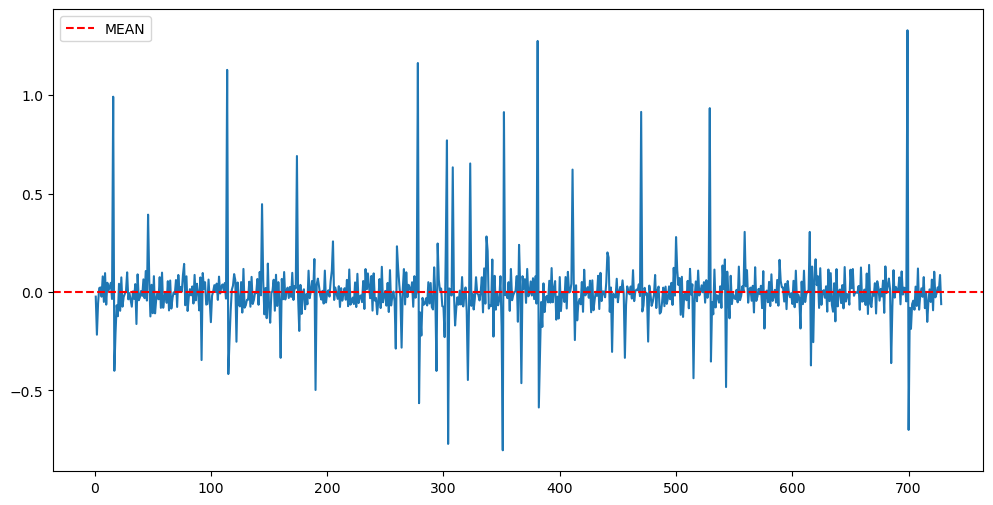

In [8]:
plt.figure(figsize=(12,6))
plt.plot(grouped_df["STATIONARY_REVENUE"].values)
plt.axhline(grouped_df["STATIONARY_REVENUE"].mean(),c="r",label="MEAN",linestyle="--")
plt.legend()

In [9]:
grouped_df.set_index("REPORT_DATE",inplace=True)
grouped_df.dropna(inplace=True)
grouped_df.head()

,IS_CODE6_ENABLED,REVENUE,STATIONARY_REVENUE
REPORT_DATE,,,
2022-01-02,True,50323396.0,-0.023944
2022-01-03,False,40495420.0,-0.217281
2022-01-04,False,38233080.0,-0.057488
2022-01-05,False,38971034.0,0.019118
2022-01-06,False,39868483.0,0.022767


### Check stationarity

In [14]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(grouped_df['REVENUE'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -10.426325592107991
p-value: 1.6541089128474231e-18


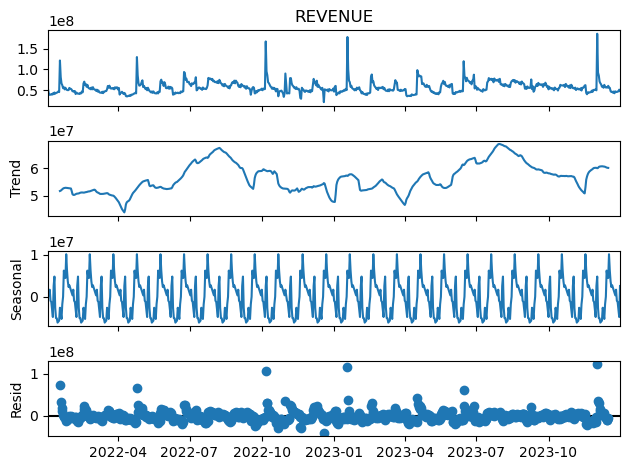

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose



result = seasonal_decompose(grouped_df['REVENUE'], model='additive',period = 30)
result.plot()
plt.show()

## Determining the parameters of the ARIMA Model

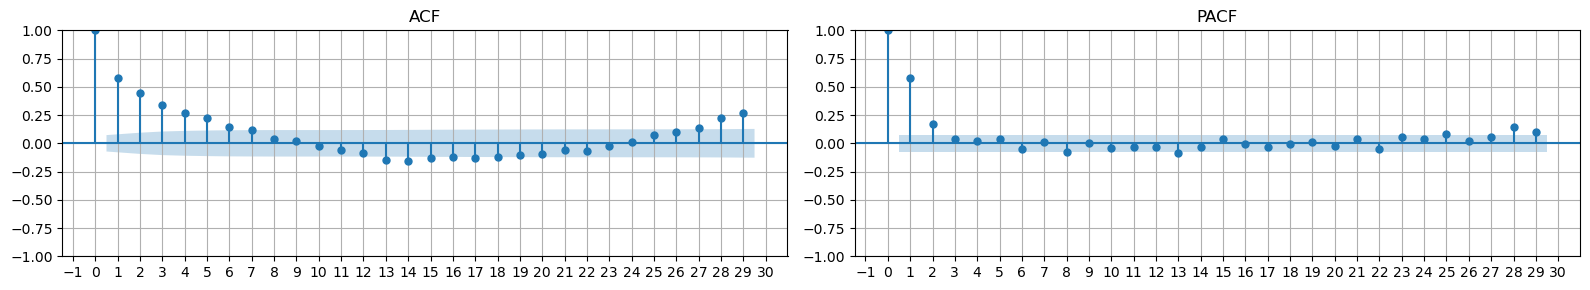

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(16, 3))

# Plot ACF
plot_acf(grouped_df['REVENUE'], ax=ax[0])
ax[0].set_title('ACF')
ax[0].grid(True) 
ax[0].xaxis.set_major_locator(plt.MultipleLocator(1))


# Plot PACF
plot_pacf(grouped_df['REVENUE'], ax=ax[1])
ax[1].set_title('PACF')
ax[1].grid(True)
ax[1].xaxis.set_major_locator(plt.MultipleLocator(1))


# Adjust layout
plt.tight_layout()
plt.show()

## Model definition and training

In [29]:
# Splitting the dataset

split_index = int(len(grouped_df)*.8)
df_train = grouped_df.iloc[:split_index]
df_test = grouped_df.iloc[split_index:]

df_train['IS_CODE6_ENABLED'] = df_train['IS_CODE6_ENABLED'].astype(int)
df_test['IS_CODE6_ENABLED'] = df_test['IS_CODE6_ENABLED'].astype(int)

C:\Users\ilyas\AppData\Local\Temp\ipykernel_8644\2481087618.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['IS_CODE6_ENABLED'] = df_train['IS_CODE6_ENABLED'].astype(int)
C:\Users\ilyas\AppData\Local\Temp\ipykernel_8644\2481087618.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['IS_CODE6_ENABLED'] = df_test['IS_CODE6_ENABLED'].astype(int)


In [30]:
from statsmodels.tsa.arima.model import ARIMA

df_train.index = pd.DatetimeIndex(df_train.index).to_period('D')
df_test.index = pd.DatetimeIndex(df_test.index).to_period('D')

In [34]:
# model definition and fitting

model = ARIMA(df_train['REVENUE'], order=(1, 0, 1),exog=df_train["IS_CODE6_ENABLED"])  # ARMA
model_fitted = model.fit()
print(model_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                REVENUE   No. Observations:                  582
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -10247.793
Date:                Thu, 15 Aug 2024   AIC                          20505.586
Time:                        15:10:20   BIC                          20527.418
Sample:                    01-02-2022   HQIC                         20514.096
                         - 08-07-2023                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             4.244e+07   3.11e-10   1.37e+17      0.000    4.24e+07    4.24e+07
IS_CODE6_ENABLED   1.55e+07   5.02e-10   3.09e+16      0.000    1.55e+07    1.55e+07
ar.L1                0.7875 

In [41]:
steps = 2 # unit in days

forecast = model_fitted.get_forecast(steps=steps,exog=df_test["IS_CODE6_ENABLED"].iloc[:steps])
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int() # The confidence interval

In [42]:
y_pred = forecast_mean.values
y_test = df_test["REVENUE"].iloc[:steps].values

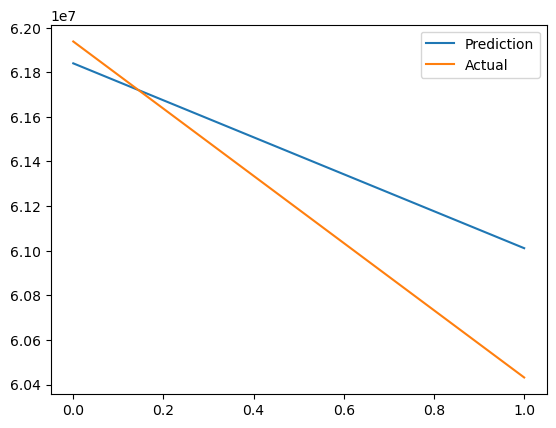

In [43]:
plt.plot(y_pred,label="Prediction")
plt.plot(y_test,label="Actual")
plt.legend()

In [44]:
mean_absolute_error(y_pred[:1],y_test[:1])

98031.08460445702

The model is able to make accurate predictions only for the first two dates.

### Trying the prediction with the SARIMA model hence there was an obvious seasonality in the plot above

In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(df_train['REVENUE'],
                       order=(1, 0, 1),         
                       seasonal_order=(1, 0, 1, 7))  

model_sarima_fitted = model_sarima.fit()

print(model_sarima_fitted.summary())

                                     SARIMAX Results                                     
Dep. Variable:                           REVENUE   No. Observations:                  582
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood              -10308.789
Date:                           Thu, 15 Aug 2024   AIC                          20627.578
Time:                                   15:12:41   BIC                          20649.410
Sample:                               01-02-2022   HQIC                         20636.088
                                    - 08-07-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7925      0.053     14.959      0.000       0.689       0.896
ma.L1         -0.2512      0.064     -3.896

In [46]:
forecast = model_sarima_fitted.get_forecast(steps=len(df_test))
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int() # The confidence interval

In [47]:
y_pred = forecast_mean.values
y_test = df_test["REVENUE"].values

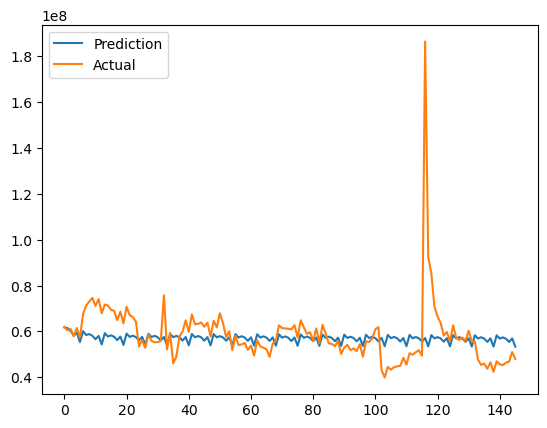

In [48]:
plt.plot(y_pred,label="Prediction")
plt.plot(y_test,label="Actual")
plt.legend()

In [49]:
mean_absolute_error(y_pred[:1],y_test[:1])

212490.96383292973